In [1]:
!pip install demoji


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 2.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

import demoji


from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

import warnings

import re
import gensim
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

import missingno as msno
from transformers import BertTokenizerFast
from transformers import TFBertModel
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier ,SGDClassifier
import tensorflow as tf
from tensorflow import keras


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
# Path = "/kaggle/input/covid-19-nlp-text-classification/"           #BOBI
Path = "/kaggle/input/covid-19-nlp-text-classification/"         #DANI 

# Data

In [4]:
train=pd.read_csv(Path + "Corona_NLP_train.csv",encoding='latin1')
test=pd.read_csv(Path + "Corona_NLP_test.csv",encoding='latin1')



df=pd.concat([train,test])
df['OriginalTweet']=df['OriginalTweet'].astype(str)
df['Sentiment']=df['Sentiment'].astype(str)

train['OriginalTweet']=train['OriginalTweet'].astype(str)
train['Sentiment']=train['Sentiment'].astype(str)

test['OriginalTweet']=test['OriginalTweet'].astype(str)
test['Sentiment']=test['Sentiment'].astype(str)
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


(44955, 6)


UserName            0
ScreenName          0
Location         9424
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64


<Axes: >

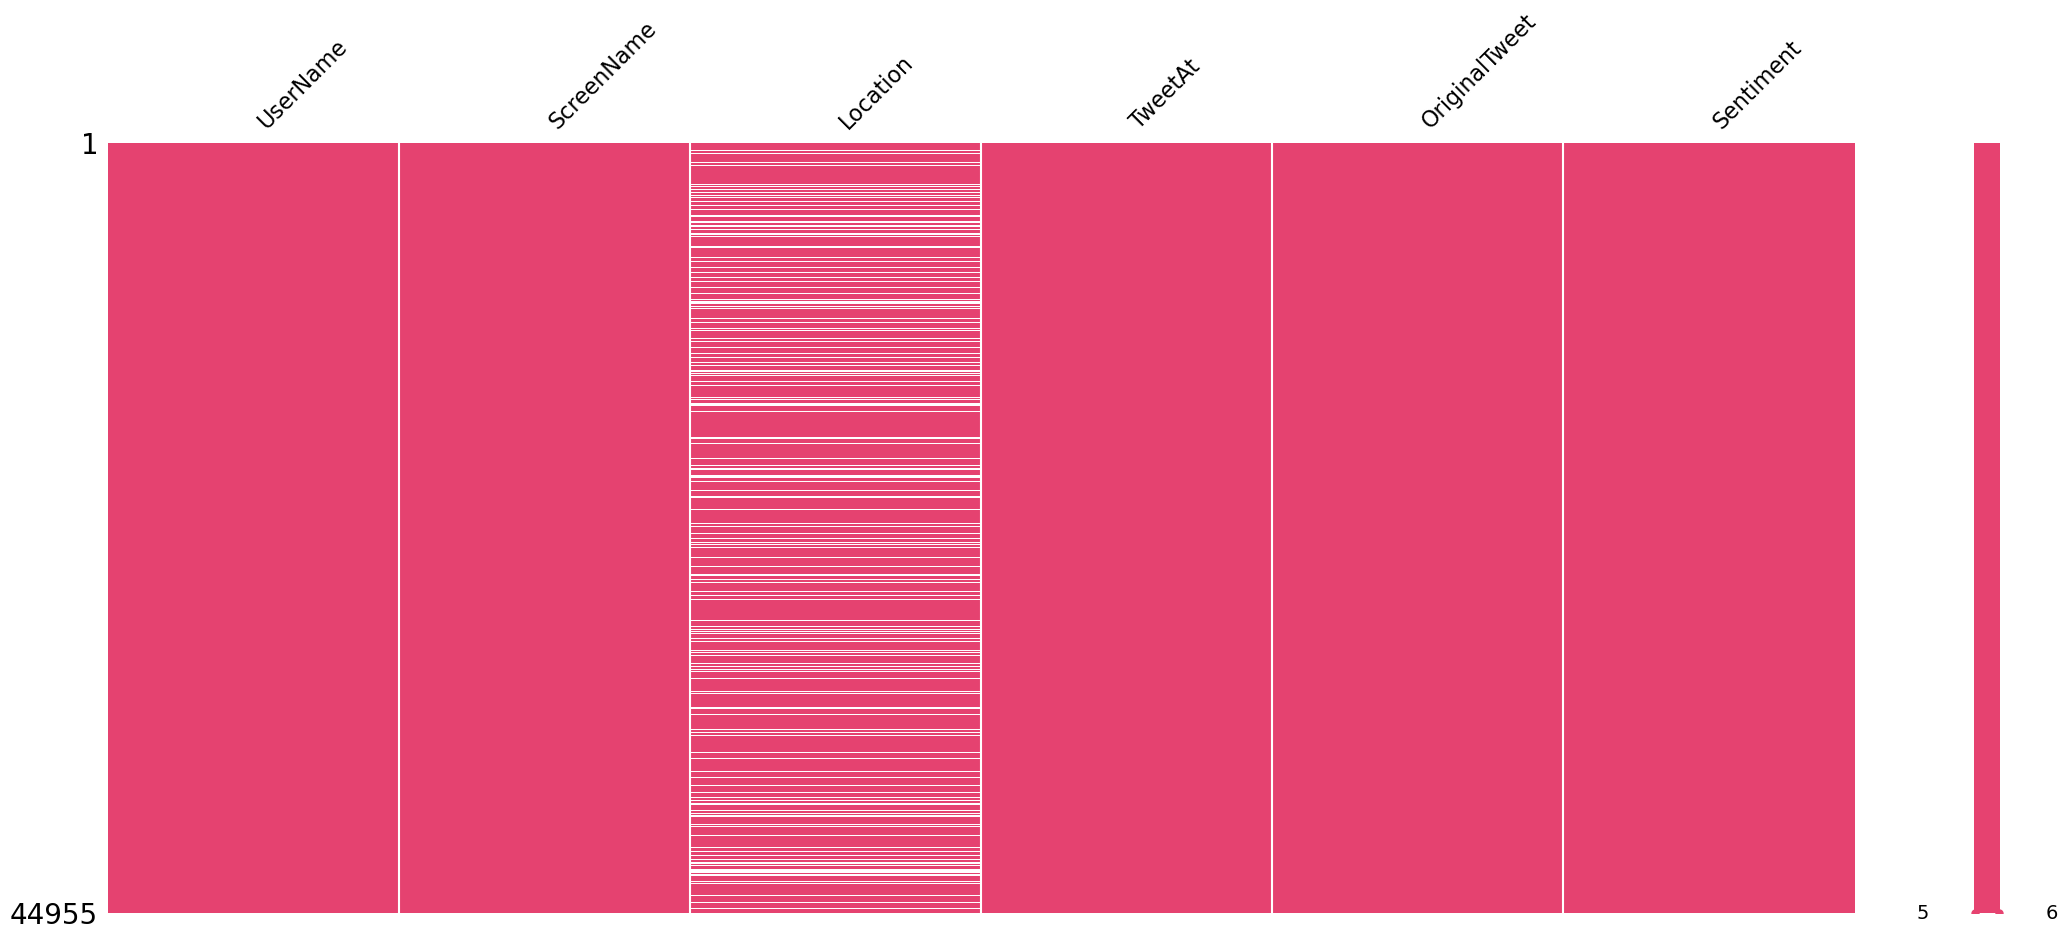

In [5]:
print(df.shape)
print("\n")
print(df.isnull().sum())
msno.matrix(df,color=(0.9,0.26,0.44))

In [6]:
print(df['UserName'].nunique(), ' ', "Unique users" )

44955   Unique users


In [7]:
print(df.Sentiment.value_counts())

Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64


In [8]:
df['text'] = df.OriginalTweet
df["text"] = df["text"].astype(str)

train['text'] = train.OriginalTweet
train["text"] = train["text"].astype(str)

test['text'] = test.OriginalTweet
test["text"] = test["text"].astype(str)

# Data has 5 classes, let's convert them to 3

def classes_def(x):
    if x ==  "Extremely Positive":
        return "positive"
    elif x == "Extremely Negative":
        return "negative"
    elif x == "Negative":
        return "negative"
    elif x ==  "Positive":
        return "positive"
    else:
        return "neutral"
    
df['sentiment']=df['Sentiment'].apply(lambda x:classes_def(x))
train['sentiment']=train['Sentiment'].apply(lambda x:classes_def(x))
test['sentiment']=test['Sentiment'].apply(lambda x:classes_def(x))
target=df['sentiment']

df.sentiment.value_counts()

positive    19592
negative    17031
neutral      8332
Name: sentiment, dtype: int64

# Class Distribution

In [9]:
class_df = df.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)

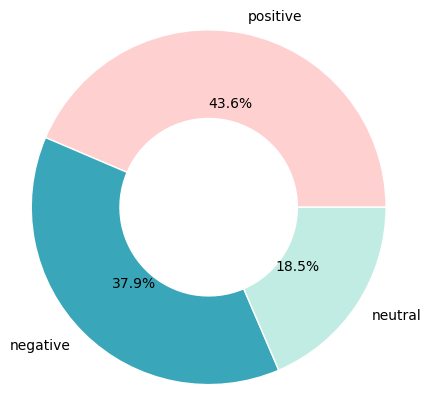

In [10]:
percent_class=class_df.text
labels= class_df.sentiment

colors = ['#FFD0D0','#3AA6B9','#C1ECE4']

my_pie,_,_ = plt.pie(percent_class,radius = 1.2,labels=labels,colors=colors,autopct="%.1f%%")

plt.setp(my_pie, width=0.6, edgecolor='white') 

plt.show()

<Axes: >

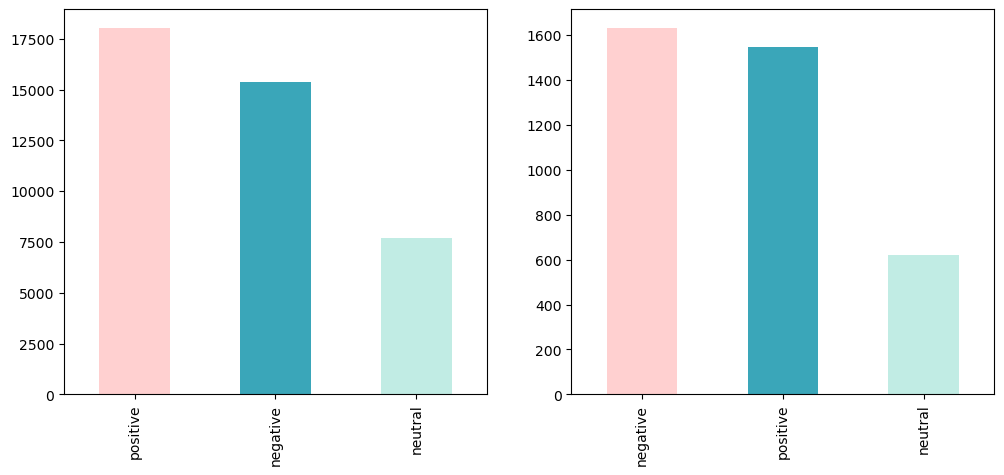

In [11]:
plt.subplot(1, 2, 1)
train["sentiment"].value_counts().plot(kind='bar',figsize=(12,5),color=colors)

plt.subplot(1, 2, 2)
test["sentiment"].value_counts().plot(kind='bar',figsize=(12,5),color=colors)

# Number of characters & words

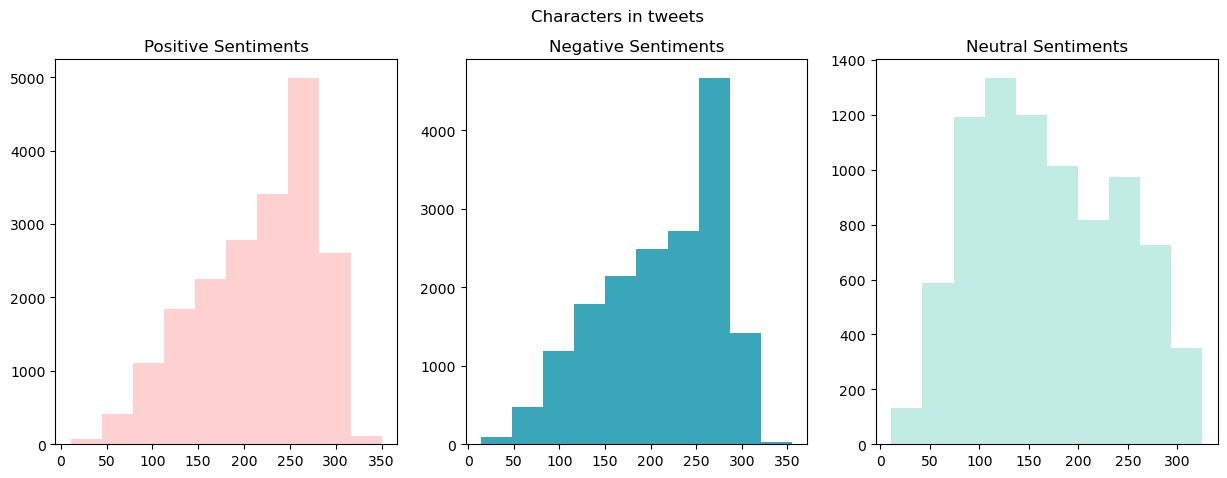

In [12]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

tweet_len=df[df['sentiment']=="positive"]['text'].str.len()
ax1.hist(tweet_len,color='#FFD0D0')
ax1.set_title('Positive Sentiments')

tweet_len=df[df['sentiment']=="negative"]['text'].str.len()
ax2.hist(tweet_len,color='#3AA6B9')
ax2.set_title('Negative Sentiments')

tweet_len=df[df['sentiment']=="neutral"]['text'].str.len()
ax3.hist(tweet_len,color='#C1ECE4')
ax3.set_title('Neutral Sentiments')

fig.suptitle('Characters in tweets')
plt.show()

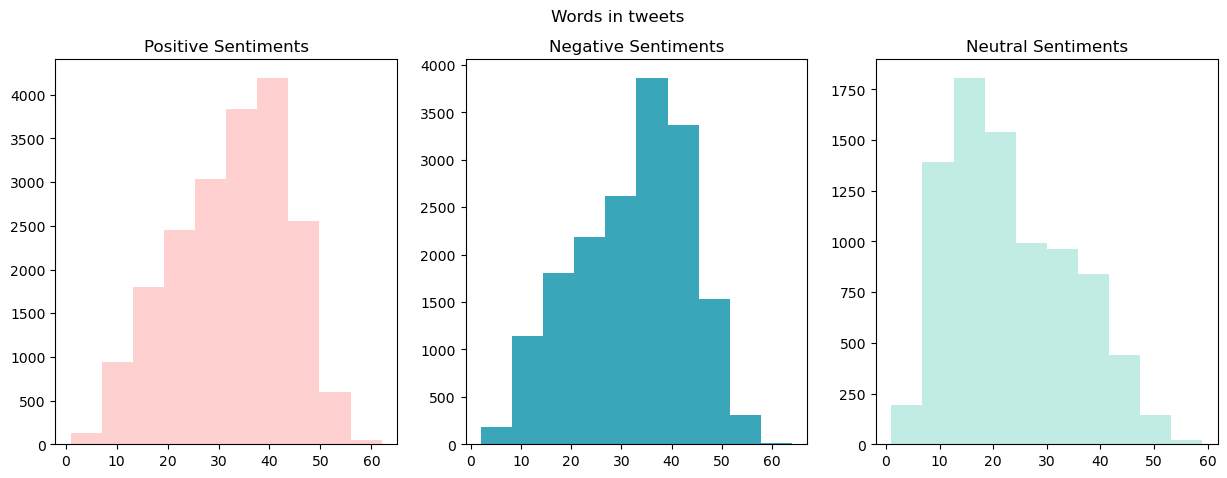

In [13]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

tweet_len=df[df['sentiment']=="positive"]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='#FFD0D0')
ax1.set_title('Positive Sentiments')

tweet_len=df[df['sentiment']=="negative"]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='#3AA6B9')
ax2.set_title('Negative Sentiments')

tweet_len=df[df['sentiment']=="neutral"]['text'].str.split().map(lambda x: len(x))
ax3.hist(tweet_len,color='#C1ECE4')
ax3.set_title('Neutral Sentiments')

fig.suptitle('Words in tweets')
plt.show()

/tmp/ipykernel_28/459186399.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='#FFD0D0')
/tmp/ipykernel_28/459186399.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='#3AA6B9')
/tmp/ipykernel_28/45918639

Text(0.5, 0.98, 'Average word length in each tweet')

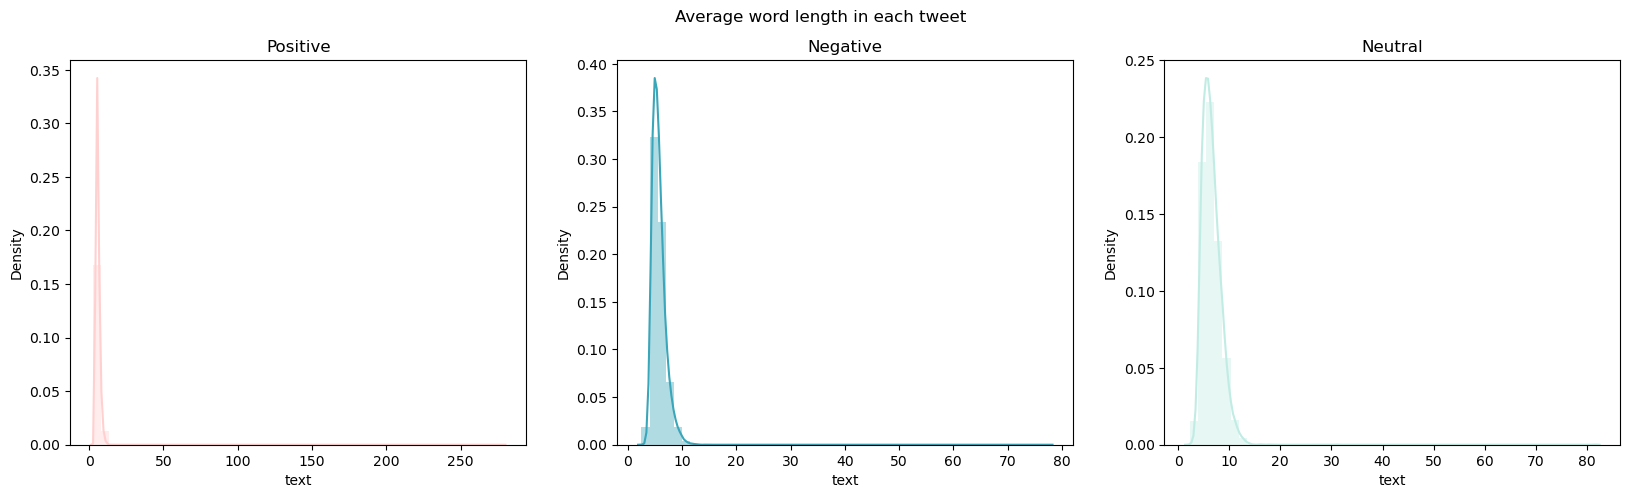

In [14]:
fig,(ax1,ax2, ax3)=plt.subplots(1,3,figsize=(20,5))

word=df[df['sentiment']=="positive"]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='#FFD0D0')
ax1.set_title('Positive')


word=df[df['sentiment']=="negative"]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='#3AA6B9')
ax2.set_title('Negative')

word=df[df['sentiment']=="neutral"]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax3,color='#C1ECE4')
ax3.set_title('Neutral')


fig.suptitle('Average word length in each tweet')

# Stopwords

In [15]:
# pip install nltk

In [16]:
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
from collections import defaultdict,Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import string
nltk.download('stopwords')

stop=set(stopwords.words('english'))
np.array(stop)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


array({'own', 'the', "wasn't", "hasn't", 'nor', 't', 'having', 'mightn', "haven't", 'o', "hadn't", 'each', 'before', 'shouldn', 'don', 'this', 'being', 'theirs', 'yourselves', 'and', 'not', 'in', "didn't", "mightn't", 'mustn', "you'd", 'more', 'ma', 'off', 'they', 'them', "isn't", 'you', 'themselves', 'aren', "should've", 'those', 'by', 'ain', "shouldn't", 'hers', 'has', 'or', 'further', 'no', "mustn't", 'at', "won't", 'y', 'am', 'wouldn', 'whom', 'should', "she's", 'but', 'himself', 'above', 'again', 'very', 'me', 'had', 'wasn', 'down', 'into', 're', 'his', 'shan', 'that', 'these', 'some', 'against', 'have', 'as', "that'll", 'does', 'doing', 'its', "weren't", 'of', 'our', 'both', "needn't", 'we', 'herself', 'been', 'because', 'myself', 'weren', 'out', 've', 'did', "don't", 'ours', 'few', 'he', 'where', 'be', 'a', 'only', 'now', 'than', 'under', 'during', "it's", 'm', 'any', 'do', "you're", 'couldn', 'hasn', 'can', 'through', 'didn', 'most', 'other', 'her', 'she', 'd', "couldn't", 'doe

In [17]:
def create_corpus(target):
    corpus=[]
    
    for x in df[df['sentiment']==target ]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

<BarContainer object of 10 artists>

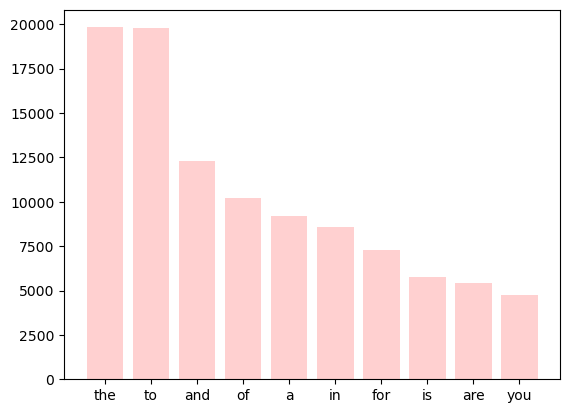

In [18]:
corpus=create_corpus("positive")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1     
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y, color='#FFD0D0')

<BarContainer object of 27 artists>

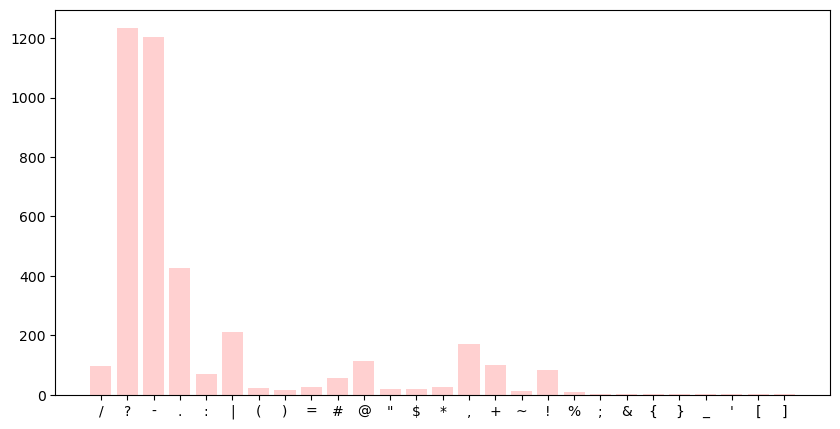

In [19]:
import string
special = string.punctuation

plt.figure(figsize=(10,5))
dic=defaultdict(int)

for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='#FFD0D0')

<BarContainer object of 10 artists>

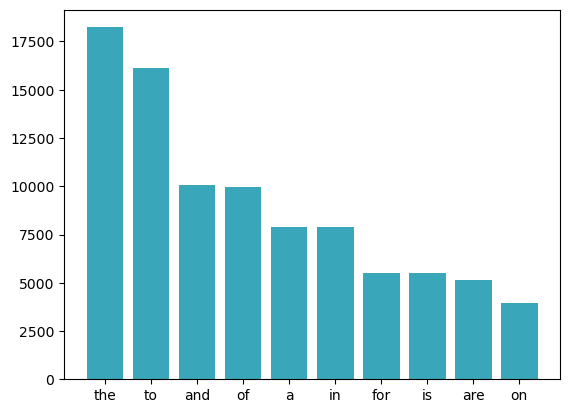

In [20]:
corpus=create_corpus("negative")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
          
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y, color='#3AA6B9')

<BarContainer object of 25 artists>

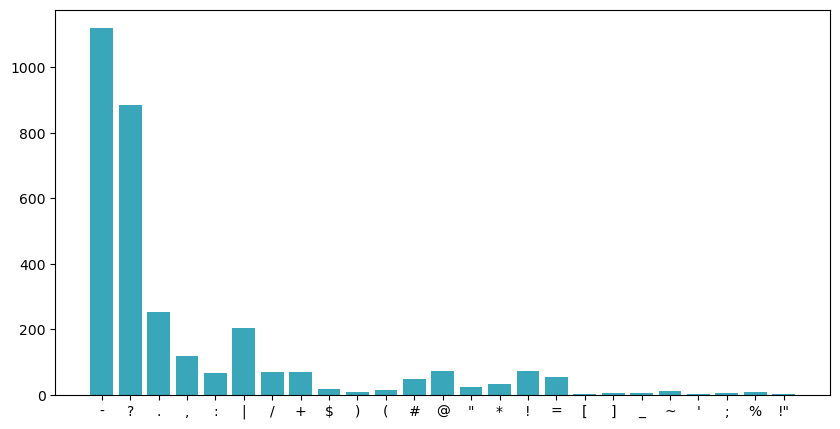

In [21]:
plt.figure(figsize=(10,5))

dic=defaultdict(int)
for i in (corpus):
    if i in special:
        dic[i]+=1
                
x,y=zip(*dic.items())
plt.bar(x,y, color='#3AA6B9')

<BarContainer object of 10 artists>

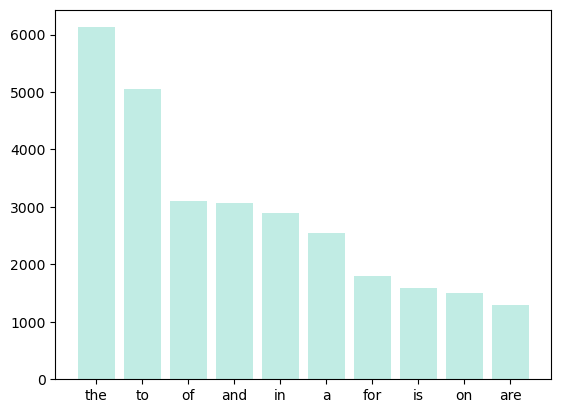

In [22]:
corpus=create_corpus("neutral")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
               
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y, color='#C1ECE4')

<BarContainer object of 24 artists>

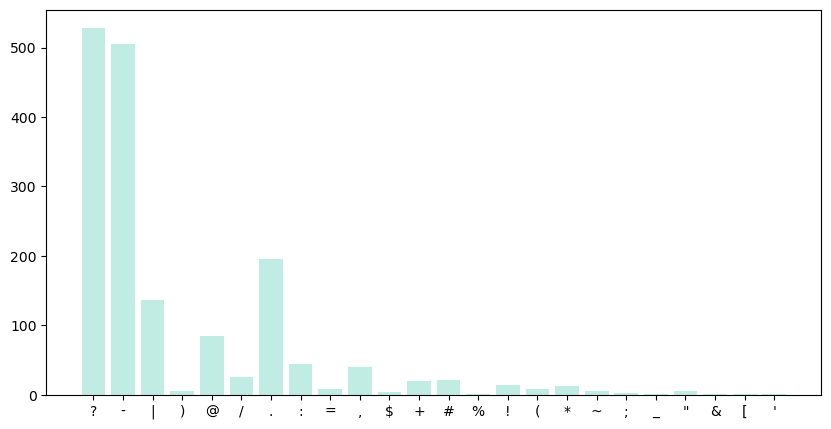

In [23]:
plt.figure(figsize=(10,5))


dic=defaultdict(int)
for i in (corpus):
    if i in special:
        dic[i]+=1

        
x,y=zip(*dic.items())
plt.bar(x,y,color='#C1ECE4')

In [24]:
counter=Counter(corpus)
most=counter.most_common()
words = []
number = []
for word,count in most[:40]:
    if (word not in stop) :
        words.append(word)
        number.append(count)

<Axes: >

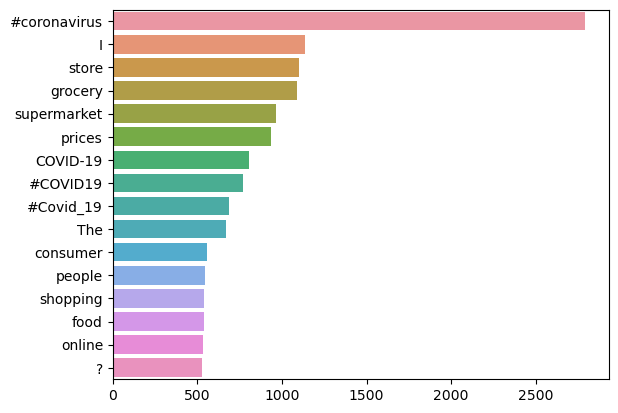

In [25]:
sns.barplot(x=number,y=words)

<Axes: xlabel='Hashtag', ylabel='count'>

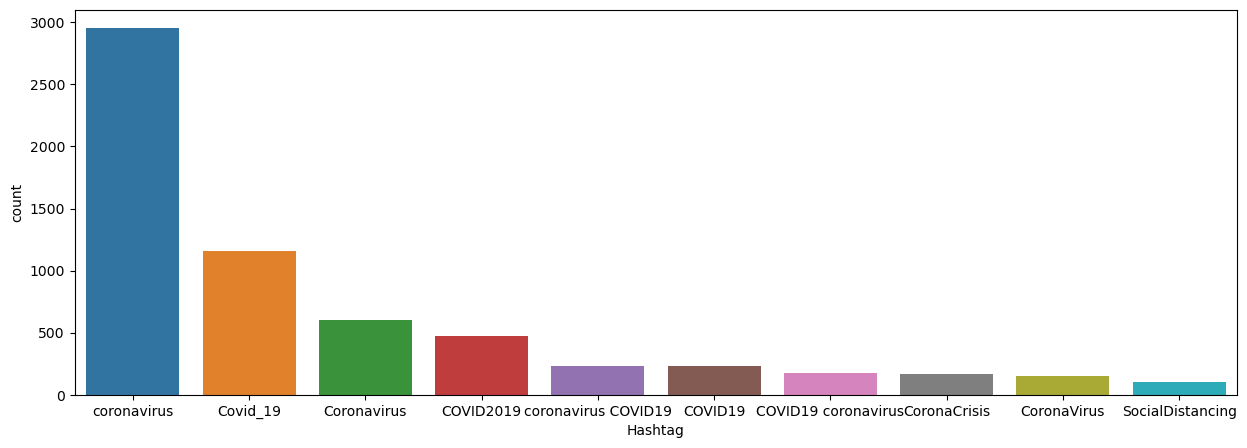

In [26]:
def find_hash(text):
    line=re.findall(r'(?<=#)\w+',text)
    return " ".join(line)
df['hash']=df['text'].apply(lambda x:find_hash(x))
temp=df['hash'].value_counts()[:][1:11]
temp= temp.to_frame().reset_index().rename(columns={'index':'Hashtag','hash':'count'})
plt.figure(figsize=(15,5))

sns.barplot(x="Hashtag",y="count", data = temp)

<Axes: xlabel='Mentions', ylabel='count'>

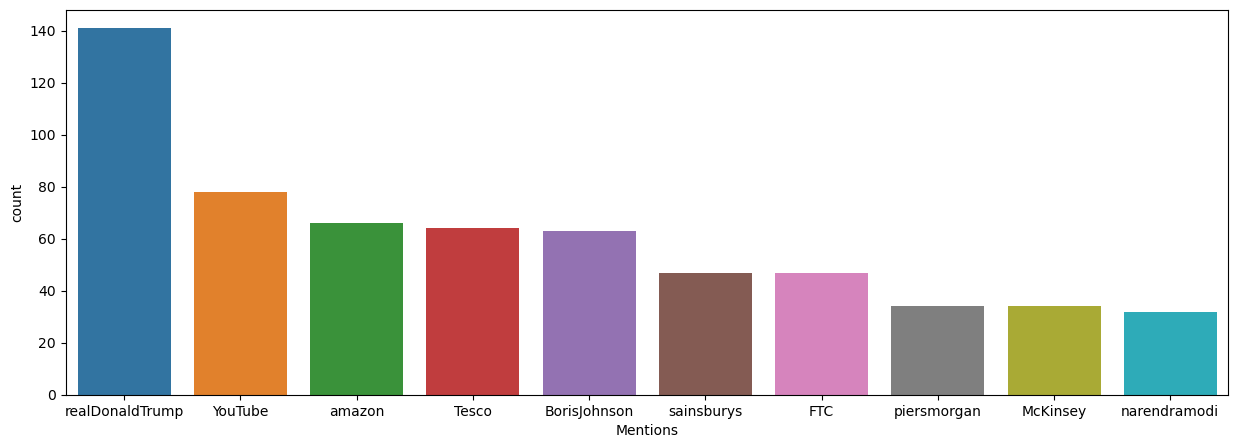

In [27]:
def mentions(text):
    line=re.findall(r'(?<=@)\w+',text)
    return " ".join(line)
df['mentions']=df['text'].apply(lambda x:mentions(x))

temp=df['mentions'].value_counts()[:][1:11]
temp =temp.to_frame().reset_index().rename(columns={'index':'Mentions','mentions':'count'})

plt.figure(figsize=(15,5))

sns.barplot(x="Mentions",y="count", data = temp)


In [28]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,text,sentiment,hash,mentions
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,neutral,,MeNyrbie Phil_Gahan Chrisitv
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice Talk to your neighbours family to excha...,positive,,
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,Coronavirus Australia: Woolworths to give elde...,positive,,
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,My food stock is not the only one which is emp...,positive,COVID19france COVID_19 COVID19 coronavirus con...,
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,"Me, ready to go at supermarket during the #COV...",negative,COVID19 coronavirus CoronavirusFrance restezch...,


In [29]:
import plotly.express as px

In [30]:
b = df['mentions'].value_counts()[:][1:11].index.tolist()
a = df['mentions'].value_counts()[:][1:11].tolist()
row = pd.DataFrame({'scenario' : []})
row["scenario"] = b
row["Percentage"] = a
fig = px.treemap(row, path= ["scenario"], values="Percentage",title='Tree of Mentions')
fig.show()

In [31]:
train = train[['OriginalTweet','Sentiment']]
test = test[['OriginalTweet','Sentiment']]


## Pre-Processing functions

In [32]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

#Clean emojis from text
def remove_emojis(text):
    return demoji.replace(text, '')


#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [33]:
train_processed = []
for t in train.OriginalTweet:
    train_processed.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(remove_emojis(t))))))

In [34]:
test_processed = []
for t in test.OriginalTweet:
    test_processed.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(remove_emojis(t))))))

In [35]:
train['text_clean'] = train_processed
test['text_clean'] = test_processed

In [36]:
train.head()

,OriginalTweet,Sentiment,text_clean
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,and and
1,advice Talk to your neighbours family to excha...,Positive,advice talk to your neighbours family to excha...
2,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths to give elder...
3,My food stock is not the only one which is emp...,Positive,my food stock is not the only one which is emp...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready to go at supermarket during the covid...


In [37]:
text_len = []
text_len_test = []

for text in train.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)
    
    
for text in test.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

In [38]:
train['text_len'] = text_len
test['text_len'] = text_len_test

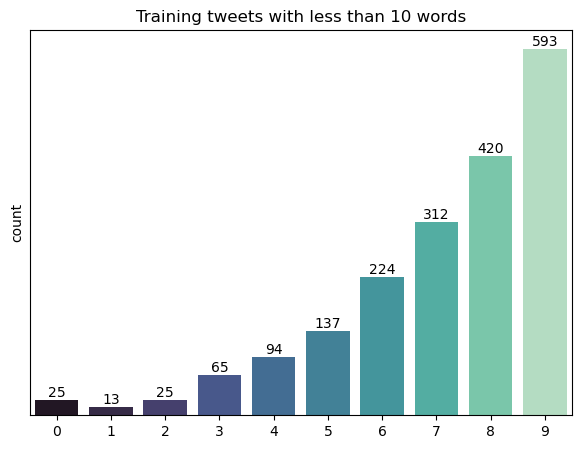

In [39]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=train[train['text_len']<10], palette='mako')
plt.title('Training tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [40]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

token_lens = []

for txt in train['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
max_len=np.max(token_lens)

print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")


MAX TOKENIZED SENTENCE LENGTH: 100


In [41]:
token_lens = []

for i,txt in enumerate(train['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")  

train['token_lens'] = token_lens
f = train.sort_values(by='token_lens', ascending=False)
train.head(20)

INDEX: 1638, TEXT: zsah policie proti spekulantm s roukami na mj popud hejtman steckho kraje ve spoluprci s podle krizovho zkona zajistil tm 700 tisrouek od firmy kter je mla dodat na zdravotnkm ale na posledn chvli se snaila navyovat cenu spolutozvladneme
INDEX: 13691, TEXT: hoy aplaudo a mi segunda familia aplaudoanuestrosheroes aquellos con los que he compartido tantas noches de trabajo y tanta alegra s que como siempre dan todo por el bien de su comunidad presidente por ellos tambin cuarentenanacionalya cuidemosalosquecuidan
INDEX: 16632, TEXT: bir mddettir spermarketlerin lojistik hizmeti avusturya ordusu desteiyle yaplyor dn corona tedavisi iin 22 milyon luk bir aratrma gelitirme btesi aklad hkmet geen hafta da 35 milyon luk 2 yardm paketi aklanmt viyanadan haberler bu kadar
INDEX: 37156, TEXT: 11 nisan cumartesi itibariyle bbnin tm hizmetleri sokaa kma serbestisi olanlar iin devam edecek halk ekmek ve hamidiye su 100 retime geti bb tm stanbulun gda ihtiyacna yetecek kapasitededi

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,and and,2,4
1,advice Talk to your neighbours family to excha...,Positive,advice talk to your neighbours family to excha...,38,42
2,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths to give elder...,13,20
3,My food stock is not the only one which is emp...,Positive,my food stock is not the only one which is emp...,41,57
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready to go at supermarket during the covid...,39,56
5,As news of the regionÂs first confirmed COVID...,Positive,as news of the regions first confirmed covid19...,34,41
6,Cashier at grocery store was sharing his insig...,Positive,cashier at grocery store was sharing his insig...,27,33
7,Was at the supermarket today. Didn't buy toile...,Neutral,was at the supermarket today didnt buy toilet ...,12,21
8,Due to COVID-19 our retail store and classroom...,Positive,due to covid19 our retail store and classroom ...,44,49
9,"For corona prevention,we should stop to buy th...",Negative,for corona preventionwe should stop to buy thi...,42,51


## Transforming the 4 classes into one

In [42]:
train['Sentiment'].value_counts()


Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [43]:
train['Sentiment'] = train['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})
test['Sentiment'] = test['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

train['Sentiment'].value_counts()
test['Sentiment'].value_counts()

0    1633
2    1546
1     619
Name: Sentiment, dtype: int64

## Train-test split and encoding

In [44]:
X = train['text_clean'].values
y = train['Sentiment'].values

In [45]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, stratify=y)

In [46]:
X_test = test['text_clean'].values
y_test = test['Sentiment'].values

# One hot encoding

In [47]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [48]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [49]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )


TRAINING DATA: 34983
VALIDATION DATA: 6174
TESTING DATA: 3798


# We use count vectorizer to tokenize the tweets

In [50]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

Then we create the TF-IDF (term-frequency times inverse document-frequency) versions of the tokenized tweets.

In [51]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

## MultiNomial Naive Bayes


In [52]:
nb_clf = MultinomialNB()
nb_clf.fit(X_train_tf, y_train_le)
print('accuracy is ',nb_clf.score(X_train_tf,y_train_le))

accuracy is  0.7225223680073178


In [53]:
nb_pred = nb_clf.predict(X_test_tf)

In [54]:
print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test_le,nb_pred, target_names=['Negative', 'Neutral', 'Positive']))


	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    Negative       0.77      0.60      0.67      1633
     Neutral       0.75      0.00      0.01       619
    Positive       0.55      0.90      0.69      1546

    accuracy                           0.63      3798
   macro avg       0.69      0.50      0.46      3798
weighted avg       0.68      0.63      0.57      3798



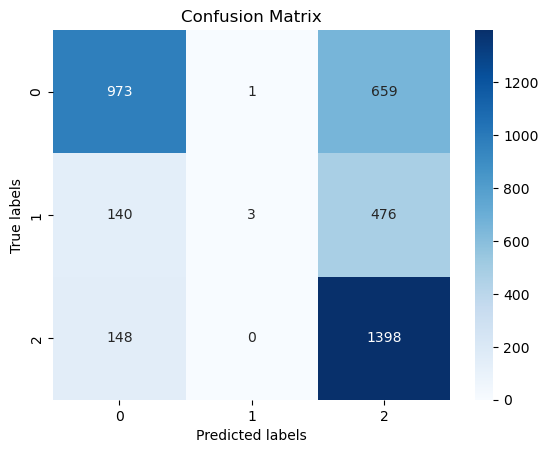

In [77]:
cm = confusion_matrix(y_test_le, nb_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

cm = confusion_matrix(y_test_le, nb_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()


## XGBOOST

In [57]:
xg_clf = SGDClassifier()
xg_clf.fit(X_train_tf, y_train_le)
print('accuracy is ',xg_clf.score(X_train_tf,y_train_le))

accuracy is  0.8656490295286282


In [58]:
xg_pred = xg_clf.predict(X_test_tf)

In [59]:
print('\tClassification Report for XGBoost:\n\n',classification_report(y_test_le, xg_pred, target_names=['Negative', 'Neutral', 'Positive']))


	Classification Report for XGBoost:

               precision    recall  f1-score   support

    Negative       0.78      0.80      0.79      1633
     Neutral       0.80      0.48      0.60       619
    Positive       0.75      0.85      0.80      1546

    accuracy                           0.77      3798
   macro avg       0.78      0.71      0.73      3798
weighted avg       0.77      0.77      0.76      3798



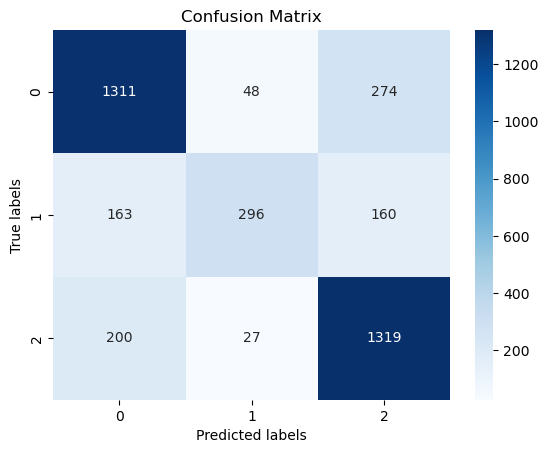

In [60]:
cm = confusion_matrix(y_test_le, xg_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()


## Bert Sentiment Analysis

In [61]:
MAX_LEN = 100

def tokenize(data,max_len= MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [62]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [63]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [64]:
def create_model(bert_model, max_len=MAX_LEN):
    
    ##params###
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    embeddings = bert_model([input_ids,attention_masks])[1]
    
    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    
    model.compile(opt, loss=loss, metrics=accuracy)
    
    
    return model

In [65]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 100,                                           

In [75]:
history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=7, batch_size=64)

Epoch 1/7
547/547 [==============================] - 735s 1s/step - loss: 0.1185 - categorical_accuracy: 0.9610 - val_loss: 0.3355 - val_categorical_accuracy: 0.9028
Epoch 2/7
547/547 [==============================] - 735s 1s/step - loss: 0.0924 - categorical_accuracy: 0.9683 - val_loss: 0.3734 - val_categorical_accuracy: 0.9027
Epoch 3/7
547/547 [==============================] - 735s 1s/step - loss: 0.0802 - categorical_accuracy: 0.9727 - val_loss: 0.3779 - val_categorical_accuracy: 0.8993
Epoch 4/7
547/547 [==============================] - 735s 1s/step - loss: 0.0689 - categorical_accuracy: 0.9770 - val_loss: 0.3937 - val_categorical_accuracy: 0.8991
Epoch 5/7
547/547 [==============================] - 735s 1s/step - loss: 0.0559 - categorical_accuracy: 0.9809 - val_loss: 0.4386 - val_categorical_accuracy: 0.8967
Epoch 6/7
547/547 [==============================] - 735s 1s/step - loss: 0.0473 - categorical_accuracy: 0.9843 - val_loss: 0.4473 - val_categorical_accuracy: 0.8937
Epoc

In [76]:
result_bert = model.predict([test_input_ids,test_attention_masks])


y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

119/119 [==============================] - 25s 213ms/step


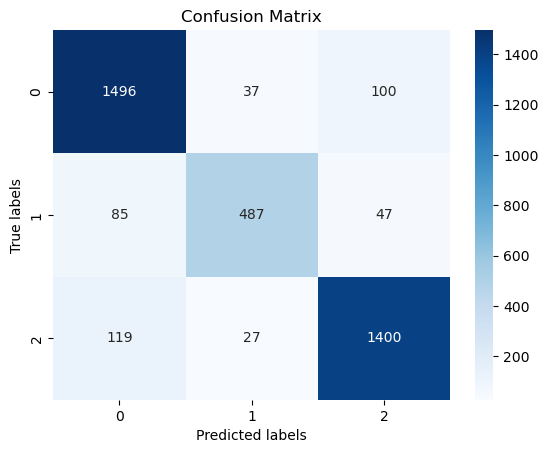

In [73]:
cm = confusion_matrix(y_test_le, result_bert.argmax(1))
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()


In [74]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for BERT:

               precision    recall  f1-score   support

    Negative       0.88      0.92      0.90      1633
     Neutral       0.88      0.79      0.83       619
    Positive       0.90      0.91      0.91      1546

   micro avg       0.89      0.89      0.89      3798
   macro avg       0.89      0.87      0.88      3798
weighted avg       0.89      0.89      0.89      3798
 samples avg       0.89      0.89      0.89      3798

